In [16]:
# https://canvas.vu.nl/courses/72644/files/folder/Assignments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

from sources.API import API_call as api
from sources.Cashflows import Cashflows

cf = Cashflows()

## Part 1: IRS

In [2]:
def standardized_maturities(zero_rates):
    """
    Standardize maturity indices for ECB data to yearly scaled indices.

    Parameters:
        zero_rates (pd.Series): Pandas Series containing zero rates with maturity indices.

    Returns:
        list: A list of standardized maturity values in years.

    This function standardizes the maturity indices provided in the ECB data to yearly scaled indices. It processes each
    maturity index, which can be in the format "X months" or "X years," and converts them into a yearly scale for
    consistent handling.
    """
    standardized_maturities = []
    for maturity in zero_rates.index:
        if 'month' in maturity:
            num_months = int(maturity.split()[0])
            standardized_maturities.append(num_months / 12.0)
        elif 'year' in maturity:
            num_years = int(maturity.split()[0])
            standardized_maturities.append(num_years)
        else:
            raise ValueError(f"Unrecognized maturity format: {maturity}")
    return standardized_maturities

# Importing Data: 
usbond_df = pd.read_excel('data/usbond_data.xlsx')
bondtest_data = pd.read_excel('data/bondtest_data.xlsx')
european_zerorates = pd.read_excel('data/european_zerorates.xlsx')
european_zerorates = european_zerorates.set_index('Maturity')
european_zerorates =  european_zerorates['AAA rated']/100 #make percentages
european_zerorates.index = standardized_maturities(european_zerorates)

Overview code: 

In [3]:
#TODO: finding a way to work with dates

In [4]:
def __determine_paymentfrequency(payment_frequency):
    """
    Determine the Pandas frequency string and number of months for a given payment frequency.

    Parameters:
        payment_frequency (float): Payment frequency (e.g., 0.5 for semi-annual).

    Returns:
        tuple: A tuple containing the Pandas frequency string and the number of months in the frequency.

    This private function maps a payment frequency to a Pandas frequency string and returns it along with the
    corresponding number of months in that frequency. It is used to determine the frequency for date range generation.
    """
    if payment_frequency == 0.5:  # Semi-annual
        freq_str = '6M'
        months = 6
    elif payment_frequency == 0.25:  # Quarterly
        freq_str = '3M'
        months = 3
    elif payment_frequency == 1:  # Annual
        freq_str = '12M'
        months = 12
    else:
        raise ValueError(f"Unsupported payment frequency: {payment_frequency}")
    return freq_str, months

def create_amortization_schedule(start_date, end_date, notional_amount, final_notional, payment_frequency):
    freq_rt = __determine_paymentfrequency(payment_frequency)[0]
    amortization_dates = pd.date_range(start=start_date, end=end_date, freq=freq_rt)
    num_periods = len(amortization_dates)
    amortization_steps = (notional_amount - final_notional) / (num_periods - 1)
    notional_amounts = []
    for i in range(num_periods):   
        amortized_notional = notional_amount - i * amortization_steps
        notional_amounts.append(amortized_notional)
    return dict(zip(amortization_dates, notional_amounts))

In [5]:
def calc_swaprate(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates, zero_rates, amortization_schedule):
    guess_rate = 0.01 #adjusting rate (precision)
    tolerance = 0.001 #difference pv between floating and fixed rate
    max_iterations = 100 
    delta_rate = 0.0001

    for i in range(max_iterations):
        floating_cash_flows = cf.calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates['euribor'], amortization_schedule)
        fixed_cash_flows = cf.calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, guess_rate, amortization_schedule)
        discounted_floating = cf.discount_cash_flows(floating_cash_flows, payment_dates, zero_rates, payment_frequency)
        discounted_fixed = cf.discount_cash_flows(fixed_cash_flows, payment_dates, zero_rates, payment_frequency)
        pv_difference = cf.discounted_fixed - discounted_floating

        fixed_cash_flows_delta = cf.calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, guess_rate + delta_rate, amortization_schedule)
        discounted_fixed_delta = cf.discount_cash_flows(fixed_cash_flows_delta, payment_dates, zero_rates, payment_frequency)
        pv_difference_delta = discounted_fixed_delta - discounted_floating

        derivative = (pv_difference_delta - pv_difference) / delta_rate
        
        # Update guess_rate using Newton-Raphson formula
        if abs(derivative) > 1e-10:  # Avoid division by zero
            guess_rate -= pv_difference / derivative
        else:
            break
        
        if abs(pv_difference) < tolerance: 
            return guess_rate
        
        guess_rate += pv_difference * 0.001  # Simplified adjustment, use a proper numerical method

    raise ValueError("Swap rate not found within maximum iterations")

In [23]:
def get_paymentdates(start_date, end_date, first_receiving_date, payment_frequency):
    freq_str, months = __determine_paymentfrequency(payment_frequency)
    print(start_date)
    adjusted_start_date = start_date + pd.DateOffset(months=int(first_receiving_date * 12))
    print(adjusted_start_date)
    #TODO there does not exists a weekly dateoffset (payment frequency) when added also change this
    payment_dates = pd.date_range(adjusted_start_date, end_date, freq=freq_str)
    return payment_dates

start_date = pd.Timestamp(datetime.datetime.now())  # Current date as start date
end_date = pd.Timestamp(datetime.datetime.now()) + pd.DateOffset(months=int(1.25 * 12))  # 1.25 years from start date
first_receiving_date = 0.25
payment_frequency = 0.5

get_paymentdates(start_date, end_date, first_receiving_date, payment_frequency)

2023-11-17 20:39:14.326653
2024-02-17 20:39:14.326653


DatetimeIndex(['2024-02-29 20:39:14.326653', '2024-08-31 20:39:14.326653'], dtype='datetime64[ns]', freq='6M')

In [10]:
def IRS_enginge(notional_amount, zero_rates, start_date, end_date, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = True, offset=3):
    """
    Calculate the net present value (NPV) of an interest rate swap.

    Parameters:
        zero_rate (pd.Series or float): Zero rates for discounting or a single zero rate if 'one_curve' is True.
        notional (float): The initial notional amount.
        start_date (pd.Timestamp): The start date of the interest rate swap.
        end_date (pd.Timestamp): The end date of the interest rate swap.
        payment_frequency (float): Payment frequency (e.g., 0.25 for quarterly, 0.5 for semi-annual, 1 for annual).
        fixed_rate (float): The fixed interest rate for the swap.
        swap_type (str, optional): Type of interest rate swap (default is 'fixed_vs_floating').
        amortization_schedule (list, optional): Amortization schedule if applicable (default is None).
        one_curve (bool, optional): Boolean flag to indicate whether to use a single curve or two curves (default is True).

    Returns:
        float: The net present value (NPV) of the interest rate swap.

    This function calculates the NPV of an interest rate swap based on the provided parameters. It takes into account the
    type of swap, payment frequency, and whether to use a single curve or two curves for discounting.
    """

    swap_rates = {'euribor': api.get_euribordata(), 'ester': api.get_esterdata(), 'fixed_rate': fixed_rate}
     
    freq_str, months = __determine_paymentfrequency(payment_frequency)
    
    if offset != None:
        adjusted_start_date = start_date - pd.DateOffset(months=offset)
        adjusted_end_date = end_date - pd.DateOffset(months=offset)
        payment_dates = pd.date_range(start=adjusted_start_date, end=adjusted_end_date, freq=freq_str)
    else: 
        payment_dates = pd.date_range(start=start_date, end=end_date, freq=freq_str)

# one curve two curve situation
    if one_curve == True:
        floating_rate_curve = zero_rates
        discount_rate_cash_flow = zero_rates
    else: 
        floating_rate_curve = zero_rates
        discount_rate_cash_flow = zero_rates- 0.002

    if is_at_initiation == False: 
        floating_cash_flows = cf.calculate_floating_cashflow(notional_amount, payment_dates, start_date, months, payment_frequency, floating_rate_curve, amortization_schedule)
        fixed_cash_flows = cf.calculate_fixed_cashflow(notional_amount, payment_dates, start_date, payment_frequency, swap_rates['fixed_rate'], amortization_schedule)
        print(floating_cash_flows)
        net_cash_flow = floating_cash_flows - fixed_cash_flows
        npv = cf.discount_cash_flows(net_cash_flow, payment_dates, discount_rate_cash_flow, payment_frequency)

        print(f'NPV using the fixed rate ({swap_rates["fixed_rate"]}): {npv}')
        return npv
    
    else:
        swap_rate = calc_swaprate(notional_amount, payment_dates, start_date, months, payment_frequency, swap_rates, zero_rates, amortization_schedule)
        print(f'Swap rate equals: {np.round(swap_rate,10)}')

        return swap_rate



In [19]:
european_zerorates

0.25     0.037837
0.50     0.036968
0.75     0.035786
1.00     0.034507
2.00     0.030124
3.00     0.027631
4.00     0.026475
5.00     0.026054
6.00     0.026015
7.00     0.026169
8.00     0.026418
9.00     0.026705
10.00    0.027002
11.00    0.027289
12.00    0.027558
13.00    0.027804
14.00    0.028024
15.00    0.028217
16.00    0.028385
17.00    0.028527
18.00    0.028646
19.00    0.028742
20.00    0.028818
21.00    0.028875
22.00    0.028915
23.00    0.028939
24.00    0.028948
25.00    0.028945
26.00    0.028930
27.00    0.028905
28.00    0.028871
29.00    0.028828
30.00    0.028778
Name: AAA rated, dtype: float64

In [18]:
import datetime

# Creating a pandas series for zero rates
zero_rates_data = dict(zip(maturities, libor_rates))
zero_rates = pd.Series(zero_rates_data)

settings = {
    'notional_amount': 100000000,  # $100 million
    'libor_rates': [0.028, 0.032, 0.034],  # 2.8%, 3.2%, 3.4%
    'maturities': [3/12, 9/12, 15/12],  # 3, 9, 15 months in years
    'fixed_rate': 0.03,  # 3%
    'payment_frequency': 0.5,  # Semiannual
    'first_receiving_date': 0.25,
    'start_date': pd.Timestamp(datetime.datetime.now()),  # Current date as start date
    'end_date': pd.Timestamp(datetime.datetime.now()) + pd.DateOffset(months=int(1.25 * 12))  # 1.25 years from start date
}




result = IRS_enginge(notional_amount, zero_rates, start_date, end_date, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = False)

[0.026      0.02998904 0.03301096]
0.25    0.028
0.75    0.032
1.25    0.034
dtype: float64
0.026000000000000002
0.25    0.028
0.75    0.032
1.25    0.034
dtype: float64
0.02998904109589041
0.25    0.028
0.75    0.032
1.25    0.034
dtype: float64
0.03301095890410959
[1300000.         1499452.05479452 1650547.94520548]
NPV using the fixed rate (0.03): -59630.21007756874


In [ ]:
notional_amount = 100
start_date = pd.to_datetime('2023-01-01')
end_date_1 = start_date + pd.DateOffset(years=10)
payment_frequency = 0.5

amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 0, payment_frequency)

fixed_rate = 0.04  # 3% fixed rate
payment_frequency = 1  # Semi-annual payments
is_at_initiation = True 
curve_settings = False #true if one curve, false if two curve

result = IRS_enginge(notional_amount, european_zerorates, start_date, end_date_1, payment_frequency, fixed_rate, amortization_schedule=amortization_schedule_1, one_curve=curve_settings, is_at_initiation = is_at_initiation)

Swap rate equals: 0.04033


In [ ]:
def adjust_rates(df, basis_points): 
    """"Assignment 1 SPFII Derivatives.pdf"
    
    """

    adjustments = basis_points/1000 #to decimals
    return df + adjustments

In [ ]:
Scenarios = {}

end_date_1 = start_date + pd.DateOffset(years=2)
# amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 50, payment_frequency)
fixed_rate = 0.04
is_at_initiation = False
Scenarios['scenario1'] = IRS_enginge(notional_amount, european_zerorates, start_date, end_date_1, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = is_at_initiation)


NPV using the fixed rate (0.04): 0.6600834944535148


In [ ]:
Scenarios['scenario_2'] = {}

# For 5-year and 7 year swap
end_date_2_5yr = start_date + pd.DateOffset(years=5)
amortization_schedule_2_5yr = create_amortization_schedule(start_date, end_date_2_5yr, notional_amount, 50, payment_frequency)
amortization_schedule_list = [None, amortization_schedule_2_5yr] 
adjust_rates_list = [0, 25,50, 100, 150]
short_term_years = [5, 7]

is_at_initiation = True
for year in short_term_years:
    print(f'> Year: {year}')
    Scenarios['scenario_2'][f'{year}yr'] = {}

    end_date_2 = start_date + pd.DateOffset(years=year)
    amortization_schedule_2 = create_amortization_schedule(start_date, end_date_2, notional_amount, 50, payment_frequency)
    amortization_schedule_list = [None, amortization_schedule_2] 

    for rate in adjust_rates_list:
        print(f'>> Change rate: {rate}')

        adjusted_rates = adjust_rates(european_zerorates.copy(), rate)
        Scenarios['scenario_2'][f'{year}yr'][f'{rate}%'] = {}
        for schedule in amortization_schedule_list:
            if schedule == None:
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['No'] = IRS_enginge(notional_amount, adjusted_rates, start_date, end_date_2, payment_frequency, fixed_rate, amortization_schedule=schedule, one_curve=True, is_at_initiation = is_at_initiation)
            else: 
                Scenarios['scenario_2'][f'{year}yr'][f'{rate}%']['Yes'] = IRS_enginge(notional_amount, adjusted_rates, start_date, end_date_2, payment_frequency, fixed_rate, amortization_schedule=schedule, one_curve=True, is_at_initiation = is_at_initiation)

> Year: 5
>> Change rate: 0
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 25
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 50
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 100
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 150
Swap rate equals: 0.04033
Swap rate equals: 0.04033
> Year: 7
>> Change rate: 0
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 25
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 50
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 100
Swap rate equals: 0.04033
Swap rate equals: 0.04033
>> Change rate: 150
Swap rate equals: 0.04033
Swap rate equals: 0.04033


In [ ]:
Scenarios = {}

print("####################### Scenario 1 ###########################")
# Scenario 1: 
end_date_1 = start_date + pd.DateOffset(years=2)
amortization_schedule_1 = create_amortization_schedule(start_date, end_date_1, notional_amount, 50, payment_frequency)
fixed_rate = 0.03
Scenarios['scenario1'] = IRS_enginge(notional_amount, european_zerorates, start_date, end_date_1, payment_frequency, fixed_rate, amortization_schedule=None, one_curve=True, is_at_initiation = is_at_initiation)

print("####################### Scenario 2 ###########################")
# Scenario 2: 

print("####################### Scenario 3 ###########################")

# Scneario 3: 
Scenarios['scenario_3'] = {}

for years in range(8, 31):
    print(f'> Year: {years}')
    end_date_3 = start_date + pd.DateOffset(years=years)
    amortization_schedule_3 = create_amortization_schedule(start_date, end_date_3, notional_amount, 50, payment_frequency)

    Scenarios['scenario_3'][f"{years}yr"] = {}
    rate_changes_bp = [-200, -100, 0, 100, 200]  # -2% (-200 bp), -1% (-100 bp), 0%, +1% (+100 bp), +2% (+200 bp)
    
    for change_bp in rate_changes_bp:
        print(f'>> Change rate: {change_bp}')

        adjusted_rates = adjust_rates(european_zerorates.copy(), change_bp)
        scenario_key = f"{change_bp/10:+.0f}%"  # e.g., "+100%", "-100%"
        Scenarios['scenario_3'][f"{years}yr"][scenario_key] = IRS_enginge(notional_amount, adjusted_rates, start_date, end_date_3, payment_frequency, fixed_rate, amortization_schedule=amortization_schedule_3, one_curve=True, is_at_initiation = is_at_initiation)

####################### Scenario 1 ###########################
Swap rate equals: 0.04033
####################### Scenario 2 ###########################
> Year: 5
>> Change rate: 0


KeyboardInterrupt: 

In [ ]:
# Save scenarios:
scenario_3_data = Scenarios['scenario_3']
df_scenario_3 = pd.DataFrame(scenario_3_data).T.to_csv('scenario3.csv')

KeyError: 'Yes'

In [ ]:
scenario_2_data

{'5yr': {'0%': {'No': -0.7815414785112651, 'Yes': -0.9648231503424398},
  '25%': {'No': -12.079616547169243, 'Yes': -9.571509041432869},
  '50%': {'No': -22.34277290076788, 'Yes': -17.523821737911923},
  '100%': {'No': -40.19090325076247, 'Yes': -31.717151971278607},
  '150%': {'No': -55.07141957838233, 'Yes': -43.98776999656234}},
 '7yr': {'0%': {'No': -0.0943014074698425, 'Yes': -0.5312406696726342},
  '25%': {'No': -15.257399520240082, 'Yes': -12.132336879373435},
  '50%': {'No': -28.405736194121808, 'Yes': -22.42394735281536},
  '100%': {'No': -49.80828871440627, 'Yes': -39.77647817296253},
  '150%': {'No': -66.19862776541339, 'Yes': -53.75038301570427}}}

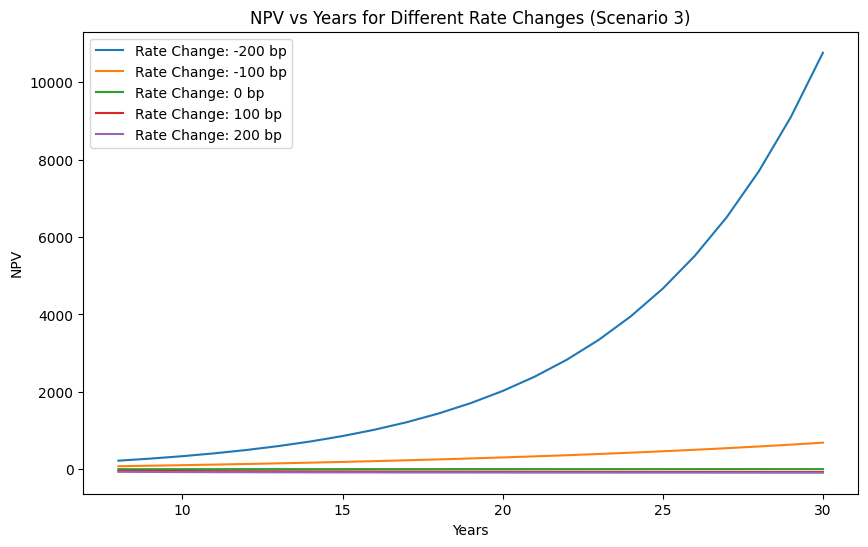

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
years = range(8, 31)  # Years from 8 to 30
rate_changes = [-200, -100, 0, 100, 200]  # Rate changes

# Initialize a plot
plt.figure(figsize=(10, 6))

# Loop over each rate change and plot the corresponding NPVs
for change in rate_changes:
    npvs = [Scenarios['scenario_3'][f"{year}yr"][f"{change/10:+.0f}%"] for year in years]
    plt.plot(years, npvs, label=f"Rate Change: {change} bp")

# Adding labels and title
plt.xlabel('Years')
plt.ylabel('NPV')
plt.title('NPV vs Years for Different Rate Changes (Scenario 3)')
plt.legend()

# Show the plot
plt.show()


## Bootstrap method: 
- Currently not sure which bonds to use to find zero rates

In [ ]:
def bootstrap_yield_curve(df, payments_per_year):
    """
    Bootstrap method to determine the zero curve based on bond data.

    Parameters:
        df (pd.DataFrame): DataFrame containing bond data with columns 'Time to Maturity', 'Bond price',
            'Bond Principal', 'Coupon per year'.
        payments_per_year (int): Number of coupon payments per year.

    Returns:
        dict: A dictionary containing zero rates for various maturities.

    This function uses the bootstrap method to determine the zero curve based on bond data provided in a DataFrame.
    It calculates zero rates for different maturities by iterating through the bonds and considering their cash flows.
    """
    zero_rates = {}

    for index, bond in df.iterrows():
        TTM = bond['Time to Maturity']
        price = bond['Bond price']
        principle = bond['Bond Principal']
        coupon_rate = bond['Coupon per year'] * payments_per_year

        if coupon_rate == 0:
            # Zero-coupon bond
            zero_rate = -np.log(price / principle) * 1 / TTM
        else:
            # Coupon-bearing bond
            total_discounted_cash_flow = []
            for t in np.arange(0.5, TTM + 0.5, 0.5):
                cash_flow = coupon_rate

                if t in zero_rates:
                    discount_factor = np.exp(-zero_rates[t] * t)
                    total_discounted_cash_flow.append(cash_flow * discount_factor)

            coupon_payment = np.sum(total_discounted_cash_flow)

            zero_rate = -np.log((price - coupon_payment) / (principle + coupon_rate)) * (1 / TTM)

        zero_rates[TTM] = zero_rate
        df.loc[index, 'zero_rate'] = zero_rate

    return zero_rates


bootstrap_yield_curve(bondtest_data, 0.5)

{0.5: 0.10469296074441824,
 1.0: 0.10536051565782628,
 1.5: 0.10680926388170528,
 2.0: 0.10808027549746793}

,-20%,-10%,+0%,+10%,+20%
8yr,219.306269,76.012841,-0.309434,-43.196357,-69.179330
9yr,272.815762,89.109003,-0.097800,-46.271836,-72.507042
10yr,335.600518,103.065132,0.099655,-49.040481,-75.303372
11yr,409.279015,117.927261,0.281333,-51.534648,-77.662366
12yr,495.713283,133.744641,0.447124,-53.783881,-79.661812
13yr,597.127416,150.574751,0.597683,-55.814070,-81.364543
14yr,716.150905,168.481646,0.734094,-57.648339,-82.821824
15yr,855.945538,187.538664,0.857624,-59.307073,-84.075262
16yr,1020.152395,207.821301,0.969657,-60.809056,-85.159374
17yr,1213.129567,229.414566,1.071534,-62.170804,-86.102166


In [ ]:
df = pd.DataFrame(Scenarios)

# Save the DataFrame to an Excel file
excel_file = 'output.xlsx'
df.to_excel(excel_file, sheet_name='Sheet1', index=False, engine='openpyxl')

print(f'Data saved to {excel_file}')

Data saved to output.xlsx
